Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
SEED = 144

Load train and test dataframes

In [3]:
train_df = pd.read_csv('data/train.csv')
print('Loaded train dataset: ', train_df.shape)

Loaded train dataset:  (177028, 782)


In [4]:
test_df = pd.read_csv('data/test.csv')
print('Loaded test dataset: ', test_df.shape)

Loaded test dataset:  (75734, 782)


Create validation datafame

In [5]:
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(train_df, test_size=0.3, random_state=12) 

print('Train dataset: ', train_df.shape)
print('Validation dataset: ', validation_df.shape)

Train dataset:  (123919, 782)
Validation dataset:  (53109, 782)


In [6]:
feature_cols = [c for c in test_df.columns if c not in ['file', 'obfuscator']]
feature_cols

['entropy;generic',
 'entropy;names',
 'entropy;values',
 'node_pairs;ArrayExpression->ArrayExpression',
 'node_pairs;ArrayExpression->ArrowFunctionExpression',
 'node_pairs;ArrayExpression->AssignmentExpression',
 'node_pairs;ArrayExpression->BinaryExpression',
 'node_pairs;ArrayExpression->CallExpression',
 'node_pairs;ArrayExpression->ConditionalExpression',
 'node_pairs;ArrayExpression->FunctionExpression',
 'node_pairs;ArrayExpression->Identifier',
 'node_pairs;ArrayExpression->Literal',
 'node_pairs;ArrayExpression->LogicalExpression',
 'node_pairs;ArrayExpression->MemberExpression',
 'node_pairs;ArrayExpression->NewExpression',
 'node_pairs;ArrayExpression->ObjectExpression',
 'node_pairs;ArrayExpression->SequenceExpression',
 'node_pairs;ArrayExpression->SpreadElement',
 'node_pairs;ArrayExpression->TaggedTemplateExpression',
 'node_pairs;ArrayExpression->TemplateLiteral',
 'node_pairs;ArrayExpression->ThisExpression',
 'node_pairs;ArrayExpression->UnaryExpression',
 'node_pair

# Train and evaluate models

## Train classifiation model

In [7]:
from sklearn import metrics
from catboost import CatBoostClassifier


np.random.seed(SEED)

feature_cols = [c for c in test_df.columns if c not in ['file', 'obfuscator']]

X_train = train_df[feature_cols].to_numpy()
X_test = test_df[feature_cols].to_numpy()
X_val = validation_df[feature_cols].to_numpy()

y_train = train_df['obfuscator'].to_numpy()
y_test = test_df['obfuscator'].to_numpy()
y_val = validation_df['obfuscator'].to_numpy()

In [8]:
model = CatBoostClassifier(
    iterations=50,
    depth=5,
    learning_rate=0.3,
    loss_function='MultiClassOneVsAll',
    verbose=True,
    random_seed=SEED,
)


model.fit(X_train, y_train, eval_set=(X_val, y_val))


preds_class = model.predict(X_test)
print(metrics.classification_report(y_test, preds_class, digits=3))

0:	learn: 0.4509406	test: 0.4510087	best: 0.4510087 (0)	total: 664ms	remaining: 32.6s
1:	learn: 0.3171219	test: 0.3172472	best: 0.3172472 (1)	total: 1.12s	remaining: 26.9s
2:	learn: 0.2247385	test: 0.2248136	best: 0.2248136 (2)	total: 1.72s	remaining: 26.9s
3:	learn: 0.1654792	test: 0.1655283	best: 0.1655283 (3)	total: 2.31s	remaining: 26.6s
4:	learn: 0.1223635	test: 0.1224303	best: 0.1224303 (4)	total: 2.9s	remaining: 26.1s
5:	learn: 0.0919845	test: 0.0920013	best: 0.0920013 (5)	total: 3.46s	remaining: 25.4s
6:	learn: 0.0703996	test: 0.0704025	best: 0.0704025 (6)	total: 3.98s	remaining: 24.5s
7:	learn: 0.0541827	test: 0.0541520	best: 0.0541520 (7)	total: 4.52s	remaining: 23.8s
8:	learn: 0.0419693	test: 0.0419297	best: 0.0419297 (8)	total: 5.06s	remaining: 23s
9:	learn: 0.0333082	test: 0.0332490	best: 0.0332490 (9)	total: 5.48s	remaining: 21.9s
10:	learn: 0.0274416	test: 0.0273974	best: 0.0273974 (10)	total: 5.92s	remaining: 21s
11:	learn: 0.0222830	test: 0.0222420	best: 0.0222420 (11)

In [9]:
features_importance_arr = model.get_feature_importance()
top_importance = sorted(
    [x for x in zip(features_importance_arr, feature_cols)],
    reverse=True,
    key=lambda x: x[0]
)
top_importance[:100]

[(11.41673401312874, 'node_pairs;Program->ExpressionStatement'),
 (11.265455991371201, 'ratios;chars_newlines'),
 (11.014686289243782, 'ratios;chars_whitespaces'),
 (8.150643870961266, 'node_pairs;Program->FunctionDeclaration'),
 (6.1964323248813615, 'ratios;chars_names_ascii_lowercase'),
 (5.383855119222352, 'nodes;EmptyStatement'),
 (4.312102718895755, 'ratios;reserved_names_fromCharCode'),
 (3.487286217581168, 'node_pairs;Program->EmptyStatement'),
 (2.7358270222019634, 'node_pairs;CallExpression->FunctionExpression'),
 (2.5359101826911092, 'node_pairs;MemberExpression->CallExpression'),
 (2.1316258297295474, 'ratios;chars_names_ascii_letters'),
 (1.8736423039820205, 'ratios;chars_digits'),
 (1.7597870595506562, 'nodes;Identifier'),
 (1.6068347929528142, 'ratios;names_quantile_100'),
 (1.6021855281888313, 'nodes;CatchClause'),
 (1.533857482486474, 'node_pairs;UnaryExpression->ArrayExpression'),
 (1.2703296271135953, 'node_pairs;CatchClause->Identifier'),
 (1.2251485435740423, 'node_

# Train detecton model

In [10]:
from sklearn import metrics
from catboost import CatBoostClassifier


np.random.seed(SEED)

feature_cols = [c for c in test_df.columns if c not in ['file', 'obfuscator']]

X_train = train_df[feature_cols].to_numpy()
X_test = test_df[feature_cols].to_numpy()
X_val = validation_df[feature_cols].to_numpy()

y_train = train_df['obfuscator'].to_numpy()
y_test = test_df['obfuscator'].to_numpy()
y_val = validation_df['obfuscator'].to_numpy()

In [11]:
def create_binary_target(a: np.array):
    return np.array([0 if x == 'original' else 1 for x in a])

y_train = create_binary_target(y_train)
y_test = create_binary_target(y_test)
y_val = create_binary_target(y_val)


In [12]:
model = CatBoostClassifier(
    iterations=15,
    depth=5, 
    learning_rate=0.05, 
    loss_function='Logloss', verbose=True, random_seed=SEED, 
    od_type='Iter',
    od_wait=70,
    eval_metric='Recall',
)


model.fit(X_train, y_train, eval_set=(X_val, y_val))


preds_class = model.predict(X_test)
print(metrics.classification_report(y_test, preds_class, digits=3))

0:	learn: 0.9928521	test: 0.9920051	best: 0.9920051 (0)	total: 71.4ms	remaining: 1s
1:	learn: 0.9928521	test: 0.9920051	best: 0.9920051 (0)	total: 138ms	remaining: 900ms
2:	learn: 0.9984683	test: 0.9986342	best: 0.9986342 (2)	total: 206ms	remaining: 826ms
3:	learn: 0.9984399	test: 0.9986009	best: 0.9986342 (2)	total: 272ms	remaining: 747ms
4:	learn: 0.9963551	test: 0.9963023	best: 0.9986342 (2)	total: 350ms	remaining: 699ms
5:	learn: 0.9980428	test: 0.9981678	best: 0.9986342 (2)	total: 412ms	remaining: 618ms
6:	learn: 0.9980712	test: 0.9982345	best: 0.9986342 (2)	total: 478ms	remaining: 546ms
7:	learn: 0.9980854	test: 0.9982345	best: 0.9986342 (2)	total: 537ms	remaining: 470ms
8:	learn: 0.9981847	test: 0.9983011	best: 0.9986342 (2)	total: 611ms	remaining: 407ms
9:	learn: 0.9981988	test: 0.9983344	best: 0.9986342 (2)	total: 682ms	remaining: 341ms
10:	learn: 0.9984258	test: 0.9986009	best: 0.9986342 (2)	total: 754ms	remaining: 274ms
11:	learn: 0.9984541	test: 0.9986009	best: 0.9986342 (2

In [13]:
OBFUSCATORS = sorted(set(train_df['obfuscator']) - {'original'})

for obfuscator in OBFUSCATORS:
    X_train = train_df[train_df['obfuscator'] != obfuscator][feature_cols].to_numpy()
    X_test = test_df[test_df['obfuscator'] != obfuscator][feature_cols].to_numpy()
    X_test_obf = test_df[test_df['obfuscator'] == obfuscator][feature_cols].to_numpy()
    X_val = validation_df[validation_df['obfuscator'] != obfuscator][feature_cols].to_numpy()

    y_train = train_df[train_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test = test_df[test_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test_obf = test_df[test_df['obfuscator'] == obfuscator]['obfuscator'].to_numpy()
    y_val = validation_df[validation_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()

    def create_binary_target(a: np.array):
        return np.array([0 if x == 'original' else 1 for x in a])

    y_train = create_binary_target(y_train)
    y_test = create_binary_target(y_test)
    y_test_obf = create_binary_target(y_test_obf)
    y_val = create_binary_target(y_val)


    print('!!!! ' + obfuscator)
                       
    model = CatBoostClassifier(
        iterations=15,
        depth=5, 
        learning_rate=0.2, 
        loss_function='Logloss', verbose=True, random_seed=SEED, 
        od_type='Iter',
        od_wait=70,
    )

    model.fit(X_train, 
              y_train, 
              sample_weight=[0.9 if y == 0 else 1.0 for y in y_train],
              eval_set=(X_val, y_val), 
              use_best_model=False
    )

    preds_class = model.predict(X_test)
    print(metrics.classification_report(y_test, preds_class, digits=4))
    
    print('!!!! ' + obfuscator)
    preds_class = model.predict(X_test_obf)
    print(metrics.classification_report(y_test_obf, preds_class, digits=4))

!!!! closure
0:	learn: 0.2384924	test: 0.2405587	best: 0.2405587 (0)	total: 65.8ms	remaining: 922ms
1:	learn: 0.1034305	test: 0.1047200	best: 0.1047200 (1)	total: 126ms	remaining: 817ms
2:	learn: 0.0482530	test: 0.0486504	best: 0.0486504 (2)	total: 189ms	remaining: 758ms
3:	learn: 0.0268898	test: 0.0273467	best: 0.0273467 (3)	total: 249ms	remaining: 686ms
4:	learn: 0.0218030	test: 0.0224828	best: 0.0224828 (4)	total: 322ms	remaining: 644ms
5:	learn: 0.0190128	test: 0.0198743	best: 0.0198743 (5)	total: 385ms	remaining: 577ms
6:	learn: 0.0157811	test: 0.0167551	best: 0.0167551 (6)	total: 441ms	remaining: 504ms
7:	learn: 0.0144873	test: 0.0154667	best: 0.0154667 (7)	total: 496ms	remaining: 434ms
8:	learn: 0.0133773	test: 0.0143630	best: 0.0143630 (8)	total: 546ms	remaining: 364ms
9:	learn: 0.0126761	test: 0.0137653	best: 0.0137653 (9)	total: 596ms	remaining: 298ms
10:	learn: 0.0121096	test: 0.0132489	best: 0.0132489 (10)	total: 654ms	remaining: 238ms
11:	learn: 0.0118247	test: 0.0130134	b

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! defendjs
0:	learn: 0.2462754	test: 0.2494391	best: 0.2494391 (0)	total: 67ms	remaining: 937ms
1:	learn: 0.0866961	test: 0.0876566	best: 0.0876566 (1)	total: 131ms	remaining: 848ms
2:	learn: 0.0502257	test: 0.0512615	best: 0.0512615 (2)	total: 183ms	remaining: 732ms
3:	learn: 0.0309970	test: 0.0318803	best: 0.0318803 (3)	total: 243ms	remaining: 667ms
4:	learn: 0.0211782	test: 0.0218405	best: 0.0218405 (4)	total: 305ms	remaining: 610ms
5:	learn: 0.0179686	test: 0.0186771	best: 0.0186771 (5)	total: 366ms	remaining: 550ms
6:	learn: 0.0152119	test: 0.0158925	best: 0.0158925 (6)	total: 428ms	remaining: 489ms
7:	learn: 0.0144110	test: 0.0152087	best: 0.0152087 (7)	total: 474ms	remaining: 415ms
8:	learn: 0.0140189	test: 0.0148818	best: 0.0148818 (8)	total: 519ms	remaining: 346ms
9:	learn: 0.0132027	test: 0.0141347	best: 0.0141347 (9)	total: 559ms	remaining: 280ms
10:	learn: 0.0127291	test: 0.0137215	best: 0.0137215 (10)	total: 605ms	remaining: 220ms
11:	learn: 0.0122364	test: 0.0132628	be

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jfogs
0:	learn: 0.2288051	test: 0.2304229	best: 0.2304229 (0)	total: 77.5ms	remaining: 1.08s
1:	learn: 0.1027480	test: 0.1025799	best: 0.1025799 (1)	total: 140ms	remaining: 907ms
2:	learn: 0.0508147	test: 0.0510615	best: 0.0510615 (2)	total: 203ms	remaining: 812ms
3:	learn: 0.0306627	test: 0.0314876	best: 0.0314876 (3)	total: 266ms	remaining: 731ms
4:	learn: 0.0201368	test: 0.0207684	best: 0.0207684 (4)	total: 337ms	remaining: 675ms
5:	learn: 0.0170842	test: 0.0178319	best: 0.0178319 (5)	total: 408ms	remaining: 611ms
6:	learn: 0.0153985	test: 0.0162839	best: 0.0162839 (6)	total: 473ms	remaining: 540ms
7:	learn: 0.0141562	test: 0.0151356	best: 0.0151356 (7)	total: 532ms	remaining: 466ms
8:	learn: 0.0131393	test: 0.0141148	best: 0.0141148 (8)	total: 581ms	remaining: 387ms
9:	learn: 0.0127665	test: 0.0138138	best: 0.0138138 (9)	total: 630ms	remaining: 315ms
10:	learn: 0.0119059	test: 0.0129950	best: 0.0129950 (10)	total: 684ms	remaining: 249ms
11:	learn: 0.0115178	test: 0.0126593	bes

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! uglifyjs
0:	learn: 0.2274813	test: 0.2276578	best: 0.2276578 (0)	total: 69.5ms	remaining: 973ms
1:	learn: 0.0895573	test: 0.0901047	best: 0.0901047 (1)	total: 130ms	remaining: 846ms
2:	learn: 0.0415977	test: 0.0418312	best: 0.0418312 (2)	total: 192ms	remaining: 769ms
3:	learn: 0.0209385	test: 0.0209917	best: 0.0209917 (3)	total: 239ms	remaining: 656ms
4:	learn: 0.0151568	test: 0.0152224	best: 0.0152224 (4)	total: 301ms	remaining: 602ms
5:	learn: 0.0121536	test: 0.0122582	best: 0.0122582 (5)	total: 354ms	remaining: 531ms
6:	learn: 0.0087410	test: 0.0088025	best: 0.0088025 (6)	total: 408ms	remaining: 466ms
7:	learn: 0.0073450	test: 0.0074747	best: 0.0074747 (7)	total: 455ms	remaining: 398ms
8:	learn: 0.0067531	test: 0.0068609	best: 0.0068609 (8)	total: 503ms	remaining: 335ms
9:	learn: 0.0061533	test: 0.0062471	best: 0.0062471 (9)	total: 559ms	remaining: 279ms
10:	learn: 0.0057553	test: 0.0058789	best: 0.0058789 (10)	total: 605ms	remaining: 220ms
11:	learn: 0.0049209	test: 0.0050328	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Detection lexical features only

In [18]:
lexical_features = [
    f for f in feature_cols 
    if not f.startswith('node')
    and not f in ['v_types', 'e_types']
]
lexical_features

['entropy;generic',
 'entropy;names',
 'entropy;values',
 'ratios;chars_another',
 'ratios;chars_ascii_letters',
 'ratios;chars_ascii_lowercase',
 'ratios;chars_ascii_uppercase',
 'ratios;chars_backslash',
 'ratios;chars_digits',
 'ratios;chars_names_another',
 'ratios;chars_names_ascii_letters',
 'ratios;chars_names_ascii_lowercase',
 'ratios;chars_names_ascii_uppercase',
 'ratios;chars_names_backslash',
 'ratios;chars_names_digits',
 'ratios;chars_names_newlines',
 'ratios;chars_names_whitespaces',
 'ratios;chars_newlines',
 'ratios;chars_values_another',
 'ratios;chars_values_ascii_letters',
 'ratios;chars_values_ascii_lowercase',
 'ratios;chars_values_ascii_uppercase',
 'ratios;chars_values_backslash',
 'ratios;chars_values_digits',
 'ratios;chars_values_newlines',
 'ratios;chars_values_whitespaces',
 'ratios;chars_whitespaces',
 'ratios;keywords_else',
 'ratios;keywords_finally',
 'ratios;names_quantile_0',
 'ratios;names_quantile_10',
 'ratios;names_quantile_100',
 'ratios;names_

In [20]:
OBFUSCATORS = sorted(set(train_df['obfuscator']) - {'original'})

for obfuscator in OBFUSCATORS:
    X_train = train_df[train_df['obfuscator'] != obfuscator][lexical_features].to_numpy()
    X_test = test_df[test_df['obfuscator'] != obfuscator][lexical_features].to_numpy()
    X_test_obf = test_df[test_df['obfuscator'] == obfuscator][lexical_features].to_numpy()
    X_val = validation_df[validation_df['obfuscator'] != obfuscator][lexical_features].to_numpy()

    y_train = train_df[train_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test = test_df[test_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test_obf = test_df[test_df['obfuscator'] == obfuscator]['obfuscator'].to_numpy()
    y_val = validation_df[validation_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()

    def create_binary_target(a: np.array):
        return np.array([0 if x == 'original' else 1 for x in a])

    y_train = create_binary_target(y_train)
    y_test = create_binary_target(y_test)
    y_test_obf = create_binary_target(y_test_obf)
    y_val = create_binary_target(y_val)


    print('!!!! ' + obfuscator)
                       
    model = CatBoostClassifier(
        iterations=15,
        depth=5, 
        learning_rate=0.2, 
        loss_function='Logloss', verbose=True, random_seed=SEED, 
        od_type='Iter',
        od_wait=70,
    )

    model.fit(X_train,
              y_train, 
              sample_weight=[0.9 if y == 0 else 1.0 for y in y_train],
              eval_set=(X_val, y_val), 
              use_best_model=False
    )

    preds_class = model.predict(X_test)
    print(metrics.classification_report(y_test, preds_class, digits=4))
    
    print('!!!! ' + obfuscator)
    preds_class = model.predict(X_test_obf)
    print(metrics.classification_report(y_test_obf, preds_class, digits=4))

!!!! closure
0:	learn: 0.3433334	test: 0.3434670	best: 0.3434670 (0)	total: 19ms	remaining: 266ms
1:	learn: 0.1964804	test: 0.1974264	best: 0.1974264 (1)	total: 38.5ms	remaining: 250ms
2:	learn: 0.1119754	test: 0.1126253	best: 0.1126253 (2)	total: 54.6ms	remaining: 219ms
3:	learn: 0.0773978	test: 0.0778883	best: 0.0778883 (3)	total: 73.2ms	remaining: 201ms
4:	learn: 0.0592756	test: 0.0600212	best: 0.0600212 (4)	total: 92ms	remaining: 184ms
5:	learn: 0.0492664	test: 0.0499399	best: 0.0499399 (5)	total: 110ms	remaining: 164ms
6:	learn: 0.0422101	test: 0.0431636	best: 0.0431636 (6)	total: 129ms	remaining: 148ms
7:	learn: 0.0385599	test: 0.0394860	best: 0.0394860 (7)	total: 146ms	remaining: 128ms
8:	learn: 0.0343724	test: 0.0352808	best: 0.0352808 (8)	total: 163ms	remaining: 108ms
9:	learn: 0.0320870	test: 0.0331460	best: 0.0331460 (9)	total: 178ms	remaining: 88.8ms
10:	learn: 0.0302932	test: 0.0315060	best: 0.0315060 (10)	total: 196ms	remaining: 71.4ms
11:	learn: 0.0279186	test: 0.0292238

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! defendjs
0:	learn: 0.3636966	test: 0.3635893	best: 0.3635893 (0)	total: 18.1ms	remaining: 253ms
1:	learn: 0.2075778	test: 0.2072848	best: 0.2072848 (1)	total: 35.5ms	remaining: 231ms
2:	learn: 0.1298132	test: 0.1301032	best: 0.1301032 (2)	total: 51.6ms	remaining: 206ms
3:	learn: 0.0895912	test: 0.0900767	best: 0.0900767 (3)	total: 68.8ms	remaining: 189ms
4:	learn: 0.0637291	test: 0.0642153	best: 0.0642153 (4)	total: 84.7ms	remaining: 169ms
5:	learn: 0.0517215	test: 0.0517495	best: 0.0517495 (5)	total: 104ms	remaining: 156ms
6:	learn: 0.0436668	test: 0.0438696	best: 0.0438696 (6)	total: 122ms	remaining: 139ms
7:	learn: 0.0378430	test: 0.0380062	best: 0.0380062 (7)	total: 141ms	remaining: 123ms
8:	learn: 0.0337535	test: 0.0340343	best: 0.0340343 (8)	total: 160ms	remaining: 107ms
9:	learn: 0.0310856	test: 0.0315200	best: 0.0315200 (9)	total: 177ms	remaining: 88.5ms
10:	learn: 0.0295445	test: 0.0301123	best: 0.0301123 (10)	total: 194ms	remaining: 70.4ms
11:	learn: 0.0265189	test: 0.02

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/an

!!!! gnirts
0:	learn: 0.4037270	test: 0.4051142	best: 0.4051142 (0)	total: 16.9ms	remaining: 236ms
1:	learn: 0.2019711	test: 0.2021668	best: 0.2021668 (1)	total: 36.5ms	remaining: 237ms
2:	learn: 0.1272779	test: 0.1278842	best: 0.1278842 (2)	total: 55.8ms	remaining: 223ms
3:	learn: 0.0914774	test: 0.0923642	best: 0.0923642 (3)	total: 74.4ms	remaining: 204ms
4:	learn: 0.0702236	test: 0.0705896	best: 0.0705896 (4)	total: 92.6ms	remaining: 185ms
5:	learn: 0.0594561	test: 0.0597321	best: 0.0597321 (5)	total: 111ms	remaining: 166ms
6:	learn: 0.0494731	test: 0.0495350	best: 0.0495350 (6)	total: 130ms	remaining: 149ms
7:	learn: 0.0424984	test: 0.0428267	best: 0.0428267 (7)	total: 149ms	remaining: 131ms
8:	learn: 0.0381554	test: 0.0384709	best: 0.0384709 (8)	total: 166ms	remaining: 111ms
9:	learn: 0.0344123	test: 0.0346466	best: 0.0346466 (9)	total: 181ms	remaining: 90.7ms
10:	learn: 0.0327136	test: 0.0331600	best: 0.0331600 (10)	total: 195ms	remaining: 71ms
11:	learn: 0.0303730	test: 0.030873

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jfogs
0:	learn: 0.3940468	test: 0.3898971	best: 0.3898971 (0)	total: 39ms	remaining: 546ms
1:	learn: 0.1900689	test: 0.1896384	best: 0.1896384 (1)	total: 64.4ms	remaining: 419ms
2:	learn: 0.0977414	test: 0.0983934	best: 0.0983934 (2)	total: 105ms	remaining: 419ms
3:	learn: 0.0558751	test: 0.0569214	best: 0.0569214 (3)	total: 129ms	remaining: 355ms
4:	learn: 0.0388527	test: 0.0397043	best: 0.0397043 (4)	total: 150ms	remaining: 299ms
5:	learn: 0.0285524	test: 0.0295844	best: 0.0295844 (5)	total: 166ms	remaining: 250ms
6:	learn: 0.0250207	test: 0.0261995	best: 0.0261995 (6)	total: 189ms	remaining: 216ms
7:	learn: 0.0226473	test: 0.0238537	best: 0.0238537 (7)	total: 210ms	remaining: 184ms
8:	learn: 0.0209350	test: 0.0222588	best: 0.0222588 (8)	total: 228ms	remaining: 152ms
9:	learn: 0.0191576	test: 0.0204690	best: 0.0204690 (9)	total: 248ms	remaining: 124ms
10:	learn: 0.0178497	test: 0.0191891	best: 0.0191891 (10)	total: 269ms	remaining: 97.6ms
11:	learn: 0.0168026	test: 0.0181403	bes

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jscrewit
0:	learn: 0.3595337	test: 0.3621002	best: 0.3621002 (0)	total: 19.6ms	remaining: 274ms
1:	learn: 0.2102564	test: 0.2112696	best: 0.2112696 (1)	total: 46.6ms	remaining: 303ms
2:	learn: 0.1263280	test: 0.1272789	best: 0.1272789 (2)	total: 65.9ms	remaining: 263ms
3:	learn: 0.0912546	test: 0.0921376	best: 0.0921376 (3)	total: 86.3ms	remaining: 237ms
4:	learn: 0.0679037	test: 0.0685663	best: 0.0685663 (4)	total: 105ms	remaining: 210ms
5:	learn: 0.0512411	test: 0.0516915	best: 0.0516915 (5)	total: 125ms	remaining: 187ms
6:	learn: 0.0410452	test: 0.0411573	best: 0.0411573 (6)	total: 145ms	remaining: 165ms
7:	learn: 0.0361287	test: 0.0363268	best: 0.0363268 (7)	total: 164ms	remaining: 144ms
8:	learn: 0.0329476	test: 0.0333167	best: 0.0333167 (8)	total: 184ms	remaining: 123ms
9:	learn: 0.0316232	test: 0.0322229	best: 0.0322229 (9)	total: 202ms	remaining: 101ms
10:	learn: 0.0296343	test: 0.0303793	best: 0.0303793 (10)	total: 221ms	remaining: 80.3ms
11:	learn: 0.0285581	test: 0.0296

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/an

!!!! jsobfu
0:	learn: 0.3871420	test: 0.3856552	best: 0.3856552 (0)	total: 19.1ms	remaining: 268ms
1:	learn: 0.2254988	test: 0.2251809	best: 0.2251809 (1)	total: 36ms	remaining: 234ms
2:	learn: 0.1271783	test: 0.1293534	best: 0.1293534 (2)	total: 58.8ms	remaining: 235ms
3:	learn: 0.0753520	test: 0.0768016	best: 0.0768016 (3)	total: 79ms	remaining: 217ms
4:	learn: 0.0547241	test: 0.0556457	best: 0.0556457 (4)	total: 96.9ms	remaining: 194ms
5:	learn: 0.0461257	test: 0.0470100	best: 0.0470100 (5)	total: 119ms	remaining: 178ms
6:	learn: 0.0375910	test: 0.0385449	best: 0.0385449 (6)	total: 135ms	remaining: 154ms
7:	learn: 0.0310699	test: 0.0320637	best: 0.0320637 (7)	total: 157ms	remaining: 137ms
8:	learn: 0.0289645	test: 0.0301666	best: 0.0301666 (8)	total: 173ms	remaining: 115ms
9:	learn: 0.0264760	test: 0.0277927	best: 0.0277927 (9)	total: 192ms	remaining: 95.9ms
10:	learn: 0.0243215	test: 0.0257691	best: 0.0257691 (10)	total: 210ms	remaining: 76.4ms
11:	learn: 0.0235275	test: 0.0249841	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! uglifyjs
0:	learn: 0.3642494	test: 0.3660524	best: 0.3660524 (0)	total: 17.9ms	remaining: 251ms
1:	learn: 0.2049570	test: 0.2072301	best: 0.2072301 (1)	total: 38.2ms	remaining: 248ms
2:	learn: 0.1151968	test: 0.1166109	best: 0.1166109 (2)	total: 60.4ms	remaining: 242ms
3:	learn: 0.0759526	test: 0.0771204	best: 0.0771204 (3)	total: 85.9ms	remaining: 236ms
4:	learn: 0.0565930	test: 0.0577916	best: 0.0577916 (4)	total: 106ms	remaining: 212ms
5:	learn: 0.0467996	test: 0.0476956	best: 0.0476956 (5)	total: 128ms	remaining: 191ms
6:	learn: 0.0394150	test: 0.0404732	best: 0.0404732 (6)	total: 148ms	remaining: 169ms
7:	learn: 0.0360968	test: 0.0373941	best: 0.0373941 (7)	total: 164ms	remaining: 143ms
8:	learn: 0.0331484	test: 0.0343685	best: 0.0343685 (8)	total: 183ms	remaining: 122ms
9:	learn: 0.0286692	test: 0.0298961	best: 0.0298961 (9)	total: 205ms	remaining: 102ms
10:	learn: 0.0265976	test: 0.0276937	best: 0.0276937 (10)	total: 220ms	remaining: 80ms
11:	learn: 0.0256585	test: 0.026894

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Detection syntactical features only

In [1]:
syntactical_features = [f for f in feature_cols if f not in lexical_features]
syntactical_features

NameError: name 'feature_cols' is not defined

In [21]:
OBFUSCATORS = sorted(set(train_df['obfuscator']) - {'original'})

for obfuscator in OBFUSCATORS:
    X_train = train_df[train_df['obfuscator'] != obfuscator][syntactical_features].to_numpy()
    X_test = test_df[test_df['obfuscator'] != obfuscator][syntactical_features].to_numpy()
    X_test_obf = test_df[test_df['obfuscator'] == obfuscator][syntactical_features].to_numpy()
    X_val = validation_df[validation_df['obfuscator'] != obfuscator][syntactical_features].to_numpy()

    y_train = train_df[train_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test = test_df[test_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test_obf = test_df[test_df['obfuscator'] == obfuscator]['obfuscator'].to_numpy()
    y_val = validation_df[validation_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()

    def create_binary_target(a: np.array):
        return np.array([0 if x == 'original' else 1 for x in a])

    y_train = create_binary_target(y_train)
    y_test = create_binary_target(y_test)
    y_test_obf = create_binary_target(y_test_obf)
    y_val = create_binary_target(y_val)


    print('!!!! ' + obfuscator)
                       
    model = CatBoostClassifier(
        iterations=15,
        depth=5, 
        learning_rate=0.2, 
        loss_function='Logloss', verbose=True, random_seed=SEED, 
        od_type='Iter',
        od_wait=70,
    )

    model.fit(X_train,
              y_train, 
              sample_weight=[0.9 if y == 0 else 1.0 for y in y_train],
              eval_set=(X_val, y_val), 
              use_best_model=False
    )

    preds_class = model.predict(X_test)
    print(metrics.classification_report(y_test, preds_class, digits=4))
    
    print('!!!! ' + obfuscator)
    preds_class = model.predict(X_test_obf)
    print(metrics.classification_report(y_test_obf, preds_class, digits=4))

!!!! closure
0:	learn: 0.3334085	test: 0.3397559	best: 0.3397559 (0)	total: 60.7ms	remaining: 850ms
1:	learn: 0.2317748	test: 0.2373779	best: 0.2373779 (1)	total: 111ms	remaining: 721ms
2:	learn: 0.1923492	test: 0.1965655	best: 0.1965655 (2)	total: 163ms	remaining: 650ms
3:	learn: 0.1752707	test: 0.1784242	best: 0.1784242 (3)	total: 214ms	remaining: 589ms
4:	learn: 0.1588146	test: 0.1611974	best: 0.1611974 (4)	total: 266ms	remaining: 532ms
5:	learn: 0.1485880	test: 0.1506924	best: 0.1506924 (5)	total: 315ms	remaining: 472ms
6:	learn: 0.1429128	test: 0.1446978	best: 0.1446978 (6)	total: 366ms	remaining: 418ms
7:	learn: 0.1378407	test: 0.1393039	best: 0.1393039 (7)	total: 412ms	remaining: 361ms
8:	learn: 0.1342930	test: 0.1355443	best: 0.1355443 (8)	total: 458ms	remaining: 305ms
9:	learn: 0.1320230	test: 0.1330960	best: 0.1330960 (9)	total: 508ms	remaining: 254ms
10:	learn: 0.1303921	test: 0.1315878	best: 0.1315878 (10)	total: 548ms	remaining: 199ms
11:	learn: 0.1285546	test: 0.1296660	b

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! defendjs
0:	learn: 0.3782601	test: 0.3853994	best: 0.3853994 (0)	total: 54.9ms	remaining: 769ms
1:	learn: 0.2752009	test: 0.2815403	best: 0.2815403 (1)	total: 108ms	remaining: 699ms
2:	learn: 0.2124351	test: 0.2174623	best: 0.2174623 (2)	total: 153ms	remaining: 611ms
3:	learn: 0.1877114	test: 0.1919923	best: 0.1919923 (3)	total: 201ms	remaining: 554ms
4:	learn: 0.1697780	test: 0.1729205	best: 0.1729205 (4)	total: 252ms	remaining: 504ms
5:	learn: 0.1607625	test: 0.1634558	best: 0.1634558 (5)	total: 306ms	remaining: 459ms
6:	learn: 0.1523181	test: 0.1544900	best: 0.1544900 (6)	total: 358ms	remaining: 409ms
7:	learn: 0.1466444	test: 0.1486297	best: 0.1486297 (7)	total: 411ms	remaining: 360ms
8:	learn: 0.1431601	test: 0.1448809	best: 0.1448809 (8)	total: 452ms	remaining: 301ms
9:	learn: 0.1407183	test: 0.1425057	best: 0.1425057 (9)	total: 497ms	remaining: 249ms
10:	learn: 0.1381000	test: 0.1398605	best: 0.1398605 (10)	total: 548ms	remaining: 199ms
11:	learn: 0.1351210	test: 0.1367764	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jfogs
0:	learn: 0.4402271	test: 0.4422066	best: 0.4422066 (0)	total: 58.5ms	remaining: 820ms
1:	learn: 0.2618722	test: 0.2673131	best: 0.2673131 (1)	total: 101ms	remaining: 656ms
2:	learn: 0.2193388	test: 0.2230768	best: 0.2230768 (2)	total: 148ms	remaining: 594ms
3:	learn: 0.1874954	test: 0.1907900	best: 0.1907900 (3)	total: 198ms	remaining: 543ms
4:	learn: 0.1699399	test: 0.1726345	best: 0.1726345 (4)	total: 241ms	remaining: 481ms
5:	learn: 0.1586319	test: 0.1609170	best: 0.1609170 (5)	total: 285ms	remaining: 428ms
6:	learn: 0.1524489	test: 0.1543368	best: 0.1543368 (6)	total: 331ms	remaining: 378ms
7:	learn: 0.1483833	test: 0.1500226	best: 0.1500226 (7)	total: 376ms	remaining: 329ms
8:	learn: 0.1455558	test: 0.1470835	best: 0.1470835 (8)	total: 416ms	remaining: 277ms
9:	learn: 0.1429476	test: 0.1443653	best: 0.1443653 (9)	total: 462ms	remaining: 231ms
10:	learn: 0.1401018	test: 0.1413960	best: 0.1413960 (10)	total: 505ms	remaining: 184ms
11:	learn: 0.1386360	test: 0.1399115	bes

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jscrewit
0:	learn: 0.3587928	test: 0.3672838	best: 0.3672838 (0)	total: 46.9ms	remaining: 657ms
1:	learn: 0.2816671	test: 0.2880786	best: 0.2880786 (1)	total: 94.2ms	remaining: 612ms
2:	learn: 0.2346989	test: 0.2392766	best: 0.2392766 (2)	total: 143ms	remaining: 570ms
3:	learn: 0.1921371	test: 0.1962916	best: 0.1962916 (3)	total: 188ms	remaining: 516ms
4:	learn: 0.1744128	test: 0.1776019	best: 0.1776019 (4)	total: 235ms	remaining: 470ms
5:	learn: 0.1612166	test: 0.1638636	best: 0.1638636 (5)	total: 282ms	remaining: 422ms
6:	learn: 0.1534696	test: 0.1556728	best: 0.1556728 (6)	total: 323ms	remaining: 369ms
7:	learn: 0.1474095	test: 0.1492309	best: 0.1492309 (7)	total: 367ms	remaining: 321ms
8:	learn: 0.1435930	test: 0.1452894	best: 0.1452894 (8)	total: 412ms	remaining: 275ms
9:	learn: 0.1412956	test: 0.1429682	best: 0.1429682 (9)	total: 458ms	remaining: 229ms
10:	learn: 0.1391088	test: 0.1406289	best: 0.1406289 (10)	total: 499ms	remaining: 181ms
11:	learn: 0.1371189	test: 0.1386349

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! uglifyjs
0:	learn: 0.2524934	test: 0.2547888	best: 0.2547888 (0)	total: 55.1ms	remaining: 772ms
1:	learn: 0.1074972	test: 0.1096027	best: 0.1096027 (1)	total: 106ms	remaining: 687ms
2:	learn: 0.0610296	test: 0.0629356	best: 0.0629356 (2)	total: 149ms	remaining: 597ms
3:	learn: 0.0376771	test: 0.0387388	best: 0.0387388 (3)	total: 204ms	remaining: 561ms
4:	learn: 0.0308220	test: 0.0317276	best: 0.0317276 (4)	total: 249ms	remaining: 497ms
5:	learn: 0.0262869	test: 0.0270318	best: 0.0270318 (5)	total: 299ms	remaining: 448ms
6:	learn: 0.0224290	test: 0.0229293	best: 0.0229293 (6)	total: 348ms	remaining: 398ms
7:	learn: 0.0205435	test: 0.0210350	best: 0.0210350 (7)	total: 392ms	remaining: 343ms
8:	learn: 0.0172150	test: 0.0175195	best: 0.0175195 (8)	total: 438ms	remaining: 292ms
9:	learn: 0.0161337	test: 0.0164624	best: 0.0164624 (9)	total: 482ms	remaining: 241ms
10:	learn: 0.0147562	test: 0.0149008	best: 0.0149008 (10)	total: 525ms	remaining: 191ms
11:	learn: 0.0129878	test: 0.0131112	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


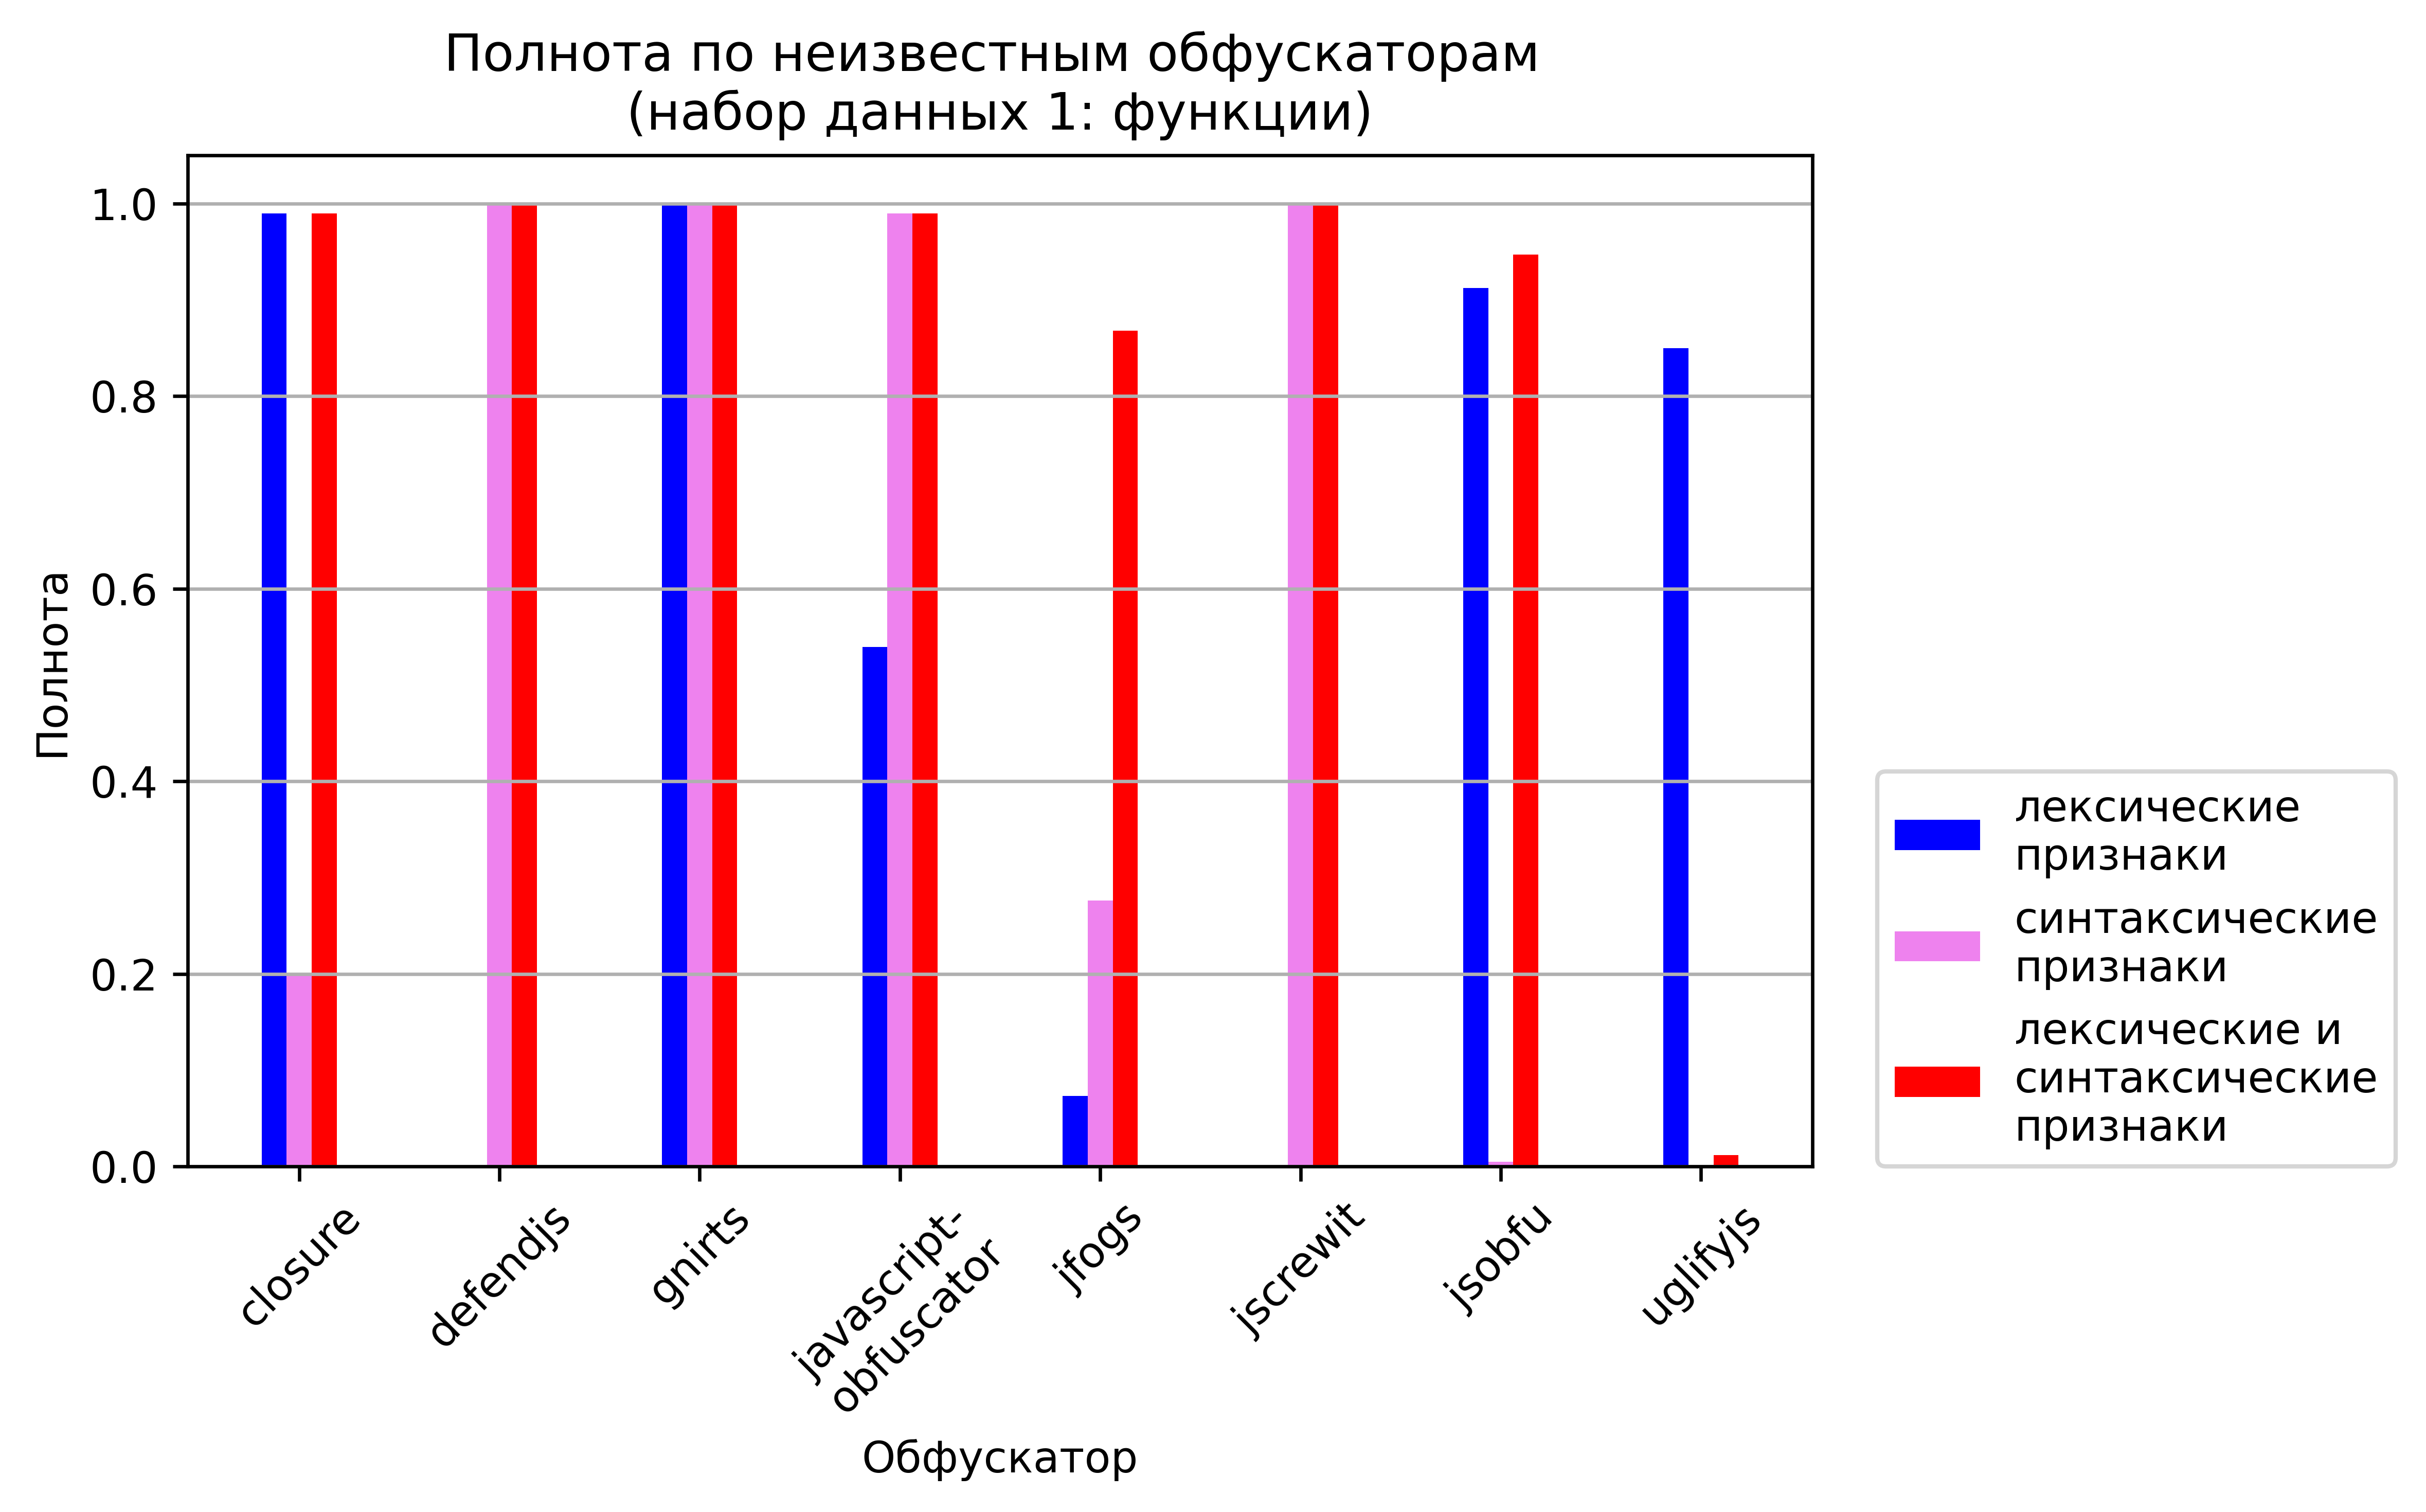

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 8
recall_ponom_lex =  [99,  0,     100,   53.96,   7.3,    0,     91.23,   85]
recall_ponom_synt = [20,  100,   100,   99,   27.6,   100,   0.5,     0.05]
recall_ponom =      [99,  100,   100,   99,   86.8,  100,   94.7,      1.18]

recall_ponom_lex = [x / 100 for x in recall_ponom_lex]
recall_ponom_synt = [x / 100 for x in recall_ponom_synt]
recall_ponom = [x / 100 for x in recall_ponom]

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
fig.set_dpi(600)

index = np.arange(n_groups) * 1
bar_width = 0.5

opacity = 0.7

rects_l = plt.bar(index - bar_width*(1/4), recall_ponom_lex, bar_width/4, alpha=1, color='blue', 
#                  label='Ponomarenko,\nKlyucharev')
#                  label='lexical')
                 label='лексические\nпризнаки')

rects_s = plt.bar(index, recall_ponom_synt, bar_width/4, alpha=1, color='violet', 
#                  label='Ponomarenko,\nKlyucharev')
                 label='синтаксические\nпризнаки')
rects_all = plt.bar(index + bar_width*(1/4), recall_ponom, bar_width/4, alpha=1, color='red', 
#                  label='Ponomarenko,\nKlyucharev')
                 label='лексические и\nсинтаксические\nпризнаки')

# plt.xlabel('Obfuscator')
# plt.ylabel('Recall')
# plt.title('Recall for unobserved obfuscator (dataset 1: functions)')

plt.xlabel('Обфускатор')
plt.ylabel('Полнота')
plt.title('Полнота по неизвестным обфускаторам \n(набор данных 1: функции)')

plt.xticks(
    index,
    ['closure', 'defendjs', 'gnirts', 'javascript-\nobfuscator', 
     'jfogs',   'jscrewit', 'jsobfu', 'uglifyjs'],
    rotation=45
)

plt.yticks([x/10 for x in range(0, 11, 2)])
plt.legend()
# plt.ylim(0, 1.5)
# plt.xlim(-0.5, np.max(index))
plt.grid(axis='y')

box = ax.get_position()

plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)

plt.tight_layout()
plt.show()

In [ ]:
# train_df = pd.read_csv('data/train.csv')
# print('Loaded train dataset: ', train_df.shape)

In [ ]:
# import collections 

# collections.Counter(
#     list(train_df['obfuscator']) + list(test_df['obfuscator'])
# )